In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import time
import psutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
labels = ['Early_Blight','Healthy','Late_Blight']

In [4]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Validation',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 163/163 [00:00<00:00, 178.82it/s]


In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4398, 224, 224, 3)
(4398,)
(486, 224, 224, 3)
(486,)


In [6]:
print(np.unique(y_test))
print(np.unique(y_train))

['Early_Blight' 'Healthy' 'Late_Blight']
['Early_Blight' 'Healthy' 'Late_Blight']


In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
all_model = pd.DataFrame(columns=['Model', 'Accuracy (Train)', 'Precision (Train)', 'Recall (Train)', 'F1 Score (Train)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'F1 Score (Test)', 'Training Time (s)', 'Testing Time (s)','Memory (MB)'])

In [9]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)


**ResNet**

In [10]:
# Define the model
base_model = tf.keras.applications.ResNet50(
    include_top=True,  # Include the fully connected layers (classifier)
    weights="imagenet",  # Use pretrained weights from ImageNet
    input_shape=(image_size, image_size, 3),  # Input size of the images
    classifier_activation="softmax",  # Activation for the output layer
)

# Modify the final dense layer for 3-class classification
model = tf.keras.models.Model(
    inputs=base_model.input,  
    outputs=tf.keras.layers.Dense(3, activation='softmax')(base_model.layers[-2].output)  # Replace the last dense layer
)

# Compile the model
model.compile(
    loss="categorical_crossentropy",  # Loss function for multi-class classification
    optimizer="Adam",  # Optimization algorithm
    metrics=["accuracy"],  # Track accuracy during training
)

# Summary of the model
model.summary()

102967424/102967424 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [11]:
import time

# Start timer
start_time = time.time()

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor ('val_loss' or 'val_accuracy')
    patience=5,                # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model
history = model.fit(
    X_train,             # Training images
    y_train,             # One-hot encoded labels
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=30,           # Number of epochs
    batch_size=32,       # Batch size for training
    verbose=1,            # Show detailed logs during training
    callbacks=[early_stopping] # Add EarlyStopping callback
)

# Measure training time
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate memory usage (optional, requires `psutil` library)
import psutil
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024
print(f"Memory Usage: {memory_usage:.2f} MB")

Epoch 1/30
110/110 [==============================] - 68s 219ms/step - loss: 0.4050 - accuracy: 0.8880 - val_loss: 8.0132 - val_accuracy: 0.7614
Epoch 2/30
110/110 [==============================] - 20s 182ms/step - loss: 0.1277 - accuracy: 0.9642 - val_loss: 1.1174 - val_accuracy: 0.7739
Epoch 3/30
110/110 [==============================] - 20s 182ms/step - loss: 0.0786 - accuracy: 0.9758 - val_loss: 0.8433 - val_accuracy: 0.8773
Epoch 4/30
110/110 [==============================] - 20s 182ms/step - loss: 0.0540 - accuracy: 0.9824 - val_loss: 0.0428 - val_accuracy: 0.9864
Epoch 5/30
110/110 [==============================] - 20s 180ms/step - loss: 0.0577 - accuracy: 0.9838 - val_loss: 1.2037 - val_accuracy: 0.8136
Epoch 6/30
110/110 [==============================] - 20s 181ms/step - loss: 0.0237 - accuracy: 0.9920 - val_loss: 0.0513 - val_accuracy: 0.9795
Epoch 7/30
110/110 [==============================] - 20s 180ms/step - loss: 0.0754 - accuracy: 0.9790 - val_loss: 2.2849 - val_ac

In [12]:
# make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
testing_time = time.time() - start_time

16/16 [==============================] - 2s 71ms/step


Confusion matrix, without normalization


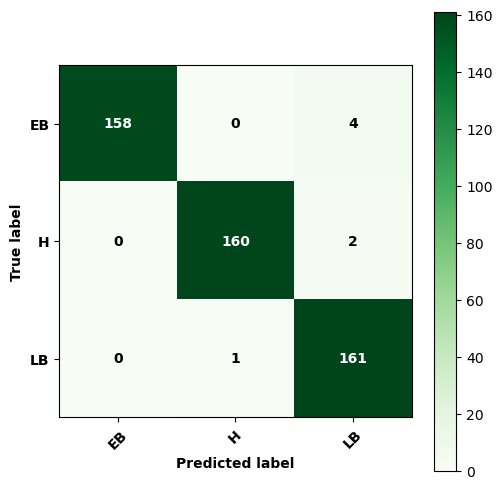

In [13]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [14]:
test_predict_class = np.argmax(y_pred, axis=1)
test_true = np.argmax(y_test, axis=1)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_test = format(accuracy_score(test_true, test_predict_class)*100,'.3f')
precision_test = format( precision_score(test_true, test_predict_class, average='macro')*100,'.3f')
recall_test = format(recall_score(test_true, test_predict_class, average='macro')*100,'.3f')
f1_test = format(f1_score(test_true, test_predict_class, average='macro')*100,'.3f')

In [16]:
# make predictions on the train data
y_pred = model.predict(X_train)

138/138 [==============================] - 7s 53ms/step


Confusion matrix, without normalization


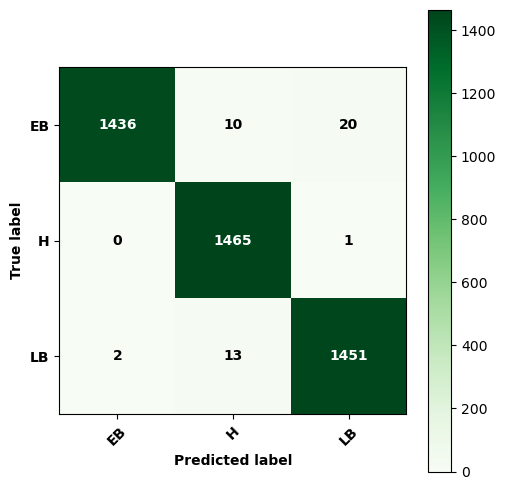

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [18]:
train_predict_class = np.argmax(y_pred, axis=1)
train_true = np.argmax(y_train, axis=1)

In [19]:
accuracy_train = format(accuracy_score(train_true, train_predict_class)*100,'.3f')
precision_train = format( precision_score(train_true, train_predict_class, average='macro')*100,'.3f')
recall_train = format(recall_score(train_true, train_predict_class, average='macro')*100,'.3f')
f1_train = format(f1_score(train_true, train_predict_class, average='macro')*100,'.3f')

In [20]:
model_name='ResNet50'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [21]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,ResNet50,98.954,98.963,98.954,98.953,98.560,98.595,98.560,98.565,228.224684,2.188679,5210.652344


**ResNet50V2**

In [22]:
# Define the model
base_model = tf.keras.applications.ResNet50V2(
    include_top=True,  # Include the fully connected layers (classifier)
    weights="imagenet",  # Use pretrained weights from ImageNet
    input_shape=(image_size, image_size, 3),  # Input size of the images
    classifier_activation="softmax",  # Activation for the output layer
)

# Modify the final dense layer for 3-class classification
model = tf.keras.models.Model(
    inputs=base_model.input,  
    outputs=tf.keras.layers.Dense(3, activation='softmax')(base_model.layers[-2].output)  # Replace the last dense layer
)

# Compile the model
model.compile(
    loss="categorical_crossentropy",  # Loss function for multi-class classification
    optimizer="Adam",  # Optimization algorithm
    metrics=["accuracy"],  # Track accuracy during training
)

# Summary of the model
model.summary()

102869336/102869336 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [23]:
import time

# Start timer
start_time = time.time()

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor ('val_loss' or 'val_accuracy')
    patience=5,                # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model
history = model.fit(
    X_train,             # Training images
    y_train,             # One-hot encoded labels
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=30,           # Number of epochs
    batch_size=32,       # Batch size for training
    verbose=1,            # Show detailed logs during training
    callbacks=[early_stopping] # Add EarlyStopping callback
)

# Measure training time
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate memory usage (optional, requires `psutil` library)
import psutil
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024
print(f"Memory Usage: {memory_usage:.2f} MB")

Epoch 1/30
110/110 [==============================] - 52s 189ms/step - loss: 0.3414 - accuracy: 0.8951 - val_loss: 3.8489 - val_accuracy: 0.7795
Epoch 2/30
110/110 [==============================] - 18s 163ms/step - loss: 0.1322 - accuracy: 0.9599 - val_loss: 1.0101 - val_accuracy: 0.8364
Epoch 3/30
110/110 [==============================] - 18s 161ms/step - loss: 0.0664 - accuracy: 0.9784 - val_loss: 1.0519 - val_accuracy: 0.8034
Epoch 4/30
110/110 [==============================] - 18s 162ms/step - loss: 0.0773 - accuracy: 0.9744 - val_loss: 0.6266 - val_accuracy: 0.8523
Epoch 5/30
110/110 [==============================] - 18s 162ms/step - loss: 0.0824 - accuracy: 0.9738 - val_loss: 0.2274 - val_accuracy: 0.9170
Epoch 6/30
110/110 [==============================] - 18s 162ms/step - loss: 0.0363 - accuracy: 0.9898 - val_loss: 0.0297 - val_accuracy: 0.9886
Epoch 7/30
110/110 [==============================] - 18s 161ms/step - loss: 0.0217 - accuracy: 0.9940 - val_loss: 0.1700 - val_ac

In [24]:
# make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
testing_time = time.time() - start_time

16/16 [==============================] - 2s 65ms/step


Confusion matrix, without normalization


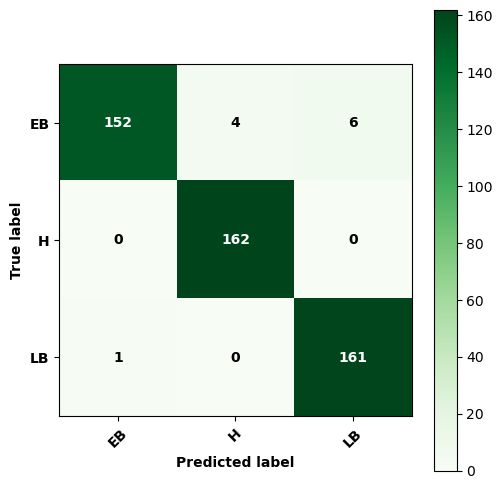

In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [26]:
test_predict_class = np.argmax(y_pred, axis=1)
test_true = np.argmax(y_test, axis=1)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_test = format(accuracy_score(test_true, test_predict_class)*100,'.3f')
precision_test = format( precision_score(test_true, test_predict_class, average='macro')*100,'.3f')
recall_test = format(recall_score(test_true, test_predict_class, average='macro')*100,'.3f')
f1_test = format(f1_score(test_true, test_predict_class, average='macro')*100,'.3f')

In [28]:
# make predictions on the train data
y_pred = model.predict(X_train)

138/138 [==============================] - 7s 49ms/step


Confusion matrix, without normalization


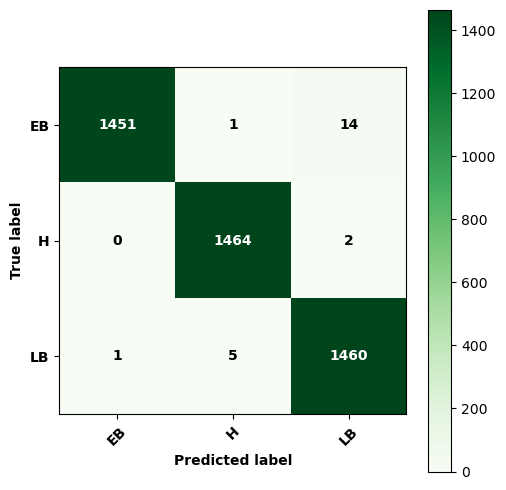

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [30]:
train_predict_class = np.argmax(y_pred, axis=1)
train_true = np.argmax(y_train, axis=1)

In [31]:
accuracy_train = format(accuracy_score(train_true, train_predict_class)*100,'.3f')
precision_train = format( precision_score(train_true, train_predict_class, average='macro')*100,'.3f')
recall_train = format(recall_score(train_true, train_predict_class, average='macro')*100,'.3f')
f1_train = format(f1_score(train_true, train_predict_class, average='macro')*100,'.3f')

In [32]:
model_name='ResNet50V2'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [33]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,ResNet50,98.954,98.963,98.954,98.953,98.560,98.595,98.560,98.565,228.224684,2.188679,5210.652344
1,ResNet50V2,99.477,99.480,99.477,99.477,97.737,97.781,97.737,97.720,231.126462,1.963836,5937.468750


**ResNet101**

In [34]:
# Define the model
base_model = tf.keras.applications.ResNet101(
    include_top=True,  # Include the fully connected layers (classifier)
    weights="imagenet",  # Use pretrained weights from ImageNet
    input_shape=(image_size, image_size, 3),  # Input size of the images
    classifier_activation="softmax",  # Activation for the output layer
)

# Modify the final dense layer for 3-class classification
model = tf.keras.models.Model(
    inputs=base_model.input,  
    outputs=tf.keras.layers.Dense(3, activation='softmax')(base_model.layers[-2].output)  # Replace the last dense layer
)

# Compile the model
model.compile(
    loss="categorical_crossentropy",  # Loss function for multi-class classification
    optimizer="Adam",  # Optimization algorithm
    metrics=["accuracy"],  # Track accuracy during training
)

# Summary of the model
model.summary()

179648224/179648224 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [35]:
import time

# Start timer
start_time = time.time()

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor ('val_loss' or 'val_accuracy')
    patience=5,                # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model
history = model.fit(
    X_train,             # Training images
    y_train,             # One-hot encoded labels
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=30,           # Number of epochs
    batch_size=32,       # Batch size for training
    verbose=1,            # Show detailed logs during training
    callbacks=[early_stopping] # Add EarlyStopping callback
)

# Measure training time
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate memory usage (optional, requires `psutil` library)
import psutil
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024
print(f"Memory Usage: {memory_usage:.2f} MB")

Epoch 1/30
110/110 [==============================] - 109s 323ms/step - loss: 0.4626 - accuracy: 0.8709 - val_loss: 53024.7852 - val_accuracy: 0.1852
Epoch 2/30
110/110 [==============================] - 33s 300ms/step - loss: 0.1371 - accuracy: 0.9642 - val_loss: 0.4646 - val_accuracy: 0.8523
Epoch 3/30
110/110 [==============================] - 33s 298ms/step - loss: 0.1119 - accuracy: 0.9693 - val_loss: 5.0610 - val_accuracy: 0.7716
Epoch 4/30
110/110 [==============================] - 33s 300ms/step - loss: 0.0911 - accuracy: 0.9736 - val_loss: 0.0248 - val_accuracy: 0.9943
Epoch 5/30
110/110 [==============================] - 33s 298ms/step - loss: 0.0640 - accuracy: 0.9810 - val_loss: 0.3618 - val_accuracy: 0.8875
Epoch 6/30
110/110 [==============================] - 33s 298ms/step - loss: 0.0444 - accuracy: 0.9872 - val_loss: 0.0854 - val_accuracy: 0.9727
Epoch 7/30
110/110 [==============================] - 33s 297ms/step - loss: 0.0654 - accuracy: 0.9804 - val_loss: 0.4185 - v

In [36]:
# make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
testing_time = time.time() - start_time

16/16 [==============================] - 3s 85ms/step


Confusion matrix, without normalization


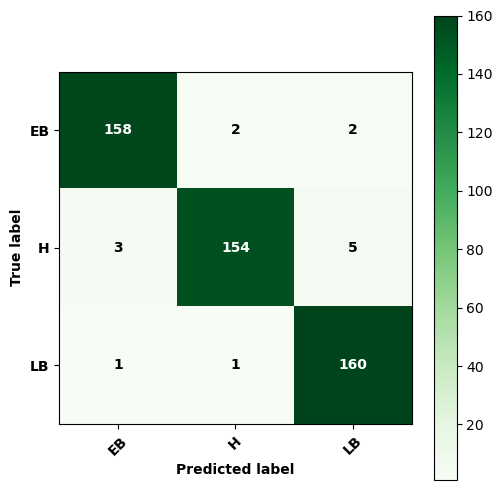

In [37]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [38]:
test_predict_class = np.argmax(y_pred, axis=1)
test_true = np.argmax(y_test, axis=1)

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_test = format(accuracy_score(test_true, test_predict_class)*100,'.3f')
precision_test = format( precision_score(test_true, test_predict_class, average='macro')*100,'.3f')
recall_test = format(recall_score(test_true, test_predict_class, average='macro')*100,'.3f')
f1_test = format(f1_score(test_true, test_predict_class, average='macro')*100,'.3f')

In [40]:
# make predictions on the train data
y_pred = model.predict(X_train)

138/138 [==============================] - 12s 84ms/step


Confusion matrix, without normalization


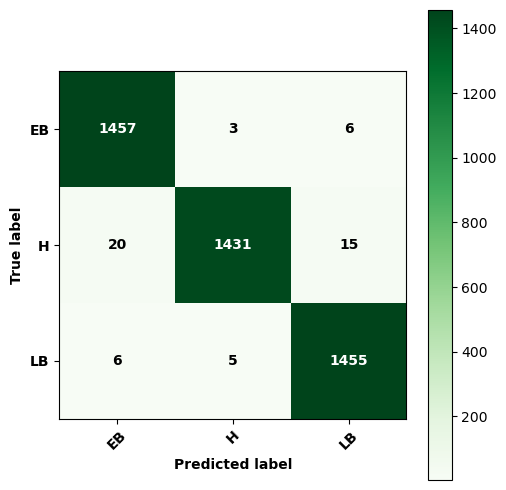

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [42]:
train_predict_class = np.argmax(y_pred, axis=1)
train_true = np.argmax(y_train, axis=1)

In [43]:
accuracy_train = format(accuracy_score(train_true, train_predict_class)*100,'.3f')
precision_train = format( precision_score(train_true, train_predict_class, average='macro')*100,'.3f')
recall_train = format(recall_score(train_true, train_predict_class, average='macro')*100,'.3f')
f1_train = format(f1_score(train_true, train_predict_class, average='macro')*100,'.3f')

In [44]:
model_name='ResNet101'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [45]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,ResNet50,98.954,98.963,98.954,98.953,98.560,98.595,98.560,98.565,228.224684,2.188679,5210.652344
1,ResNet50V2,99.477,99.480,99.477,99.477,97.737,97.781,97.737,97.720,231.126462,1.963836,5937.468750
2,ResNet101,98.749,98.756,98.749,98.748,97.119,97.143,97.119,97.116,373.155548,3.202658,6855.910156


**ResNet101V2**

In [46]:
# Define the model
base_model = tf.keras.applications.ResNet101V2(
    include_top=True,  # Include the fully connected layers (classifier)
    weights="imagenet",  # Use pretrained weights from ImageNet
    input_shape=(image_size, image_size, 3),  # Input size of the images
    classifier_activation="softmax",  # Activation for the output layer
)

# Modify the final dense layer for 3-class classification
model = tf.keras.models.Model(
    inputs=base_model.input,  
    outputs=tf.keras.layers.Dense(3, activation='softmax')(base_model.layers[-2].output)  # Replace the last dense layer
)

# Compile the model
model.compile(
    loss="categorical_crossentropy",  # Loss function for multi-class classification
    optimizer="Adam",  # Optimization algorithm
    metrics=["accuracy"],  # Track accuracy during training
)

# Summary of the model
model.summary()

179518384/179518384 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [47]:
import time

# Start timer
start_time = time.time()

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor ('val_loss' or 'val_accuracy')
    patience=5,                # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model
history = model.fit(
    X_train,             # Training images
    y_train,             # One-hot encoded labels
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=30,           # Number of epochs
    batch_size=32,       # Batch size for training
    verbose=1,            # Show detailed logs during training
    callbacks=[early_stopping] # Add EarlyStopping callback
)

# Measure training time
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate memory usage (optional, requires `psutil` library)
import psutil
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024
print(f"Memory Usage: {memory_usage:.2f} MB")

Epoch 1/30
110/110 [==============================] - 98s 305ms/step - loss: 0.4749 - accuracy: 0.8294 - val_loss: 82.3188 - val_accuracy: 0.1841
Epoch 2/30
110/110 [==============================] - 31s 283ms/step - loss: 0.2009 - accuracy: 0.9358 - val_loss: 0.6339 - val_accuracy: 0.9068
Epoch 3/30
110/110 [==============================] - 31s 283ms/step - loss: 0.1594 - accuracy: 0.9471 - val_loss: 0.3149 - val_accuracy: 0.9068
Epoch 4/30
110/110 [==============================] - 31s 281ms/step - loss: 0.1227 - accuracy: 0.9656 - val_loss: 1.8565 - val_accuracy: 0.6761
Epoch 5/30
110/110 [==============================] - 31s 282ms/step - loss: 0.0889 - accuracy: 0.9758 - val_loss: 0.0963 - val_accuracy: 0.9670
Epoch 6/30
110/110 [==============================] - 31s 280ms/step - loss: 0.0734 - accuracy: 0.9795 - val_loss: 0.1577 - val_accuracy: 0.9420
Epoch 7/30
110/110 [==============================] - 31s 280ms/step - loss: 0.0776 - accuracy: 0.9761 - val_loss: 0.1077 - val_a

In [48]:
# make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
testing_time = time.time() - start_time

16/16 [==============================] - 3s 83ms/step


Confusion matrix, without normalization


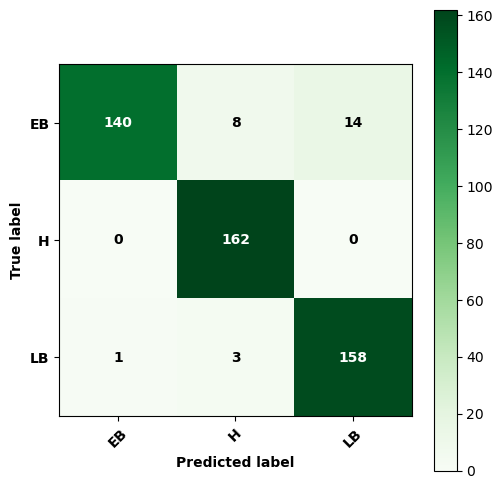

In [49]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [50]:
test_predict_class = np.argmax(y_pred, axis=1)
test_true = np.argmax(y_test, axis=1)

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_test = format(accuracy_score(test_true, test_predict_class)*100,'.3f')
precision_test = format( precision_score(test_true, test_predict_class, average='macro')*100,'.3f')
recall_test = format(recall_score(test_true, test_predict_class, average='macro')*100,'.3f')
f1_test = format(f1_score(test_true, test_predict_class, average='macro')*100,'.3f')

In [52]:
# make predictions on the train data
y_pred = model.predict(X_train)

138/138 [==============================] - 11s 82ms/step


Confusion matrix, without normalization


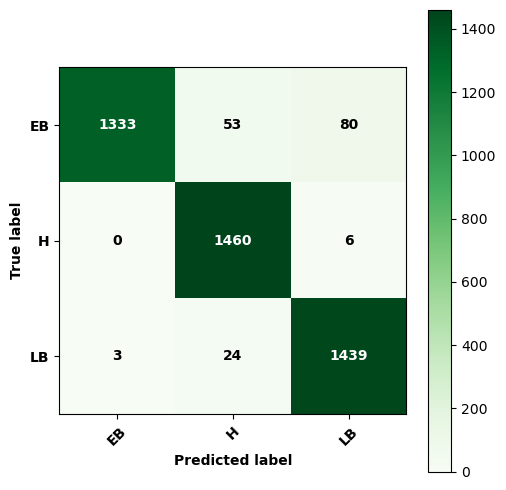

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [54]:
train_predict_class = np.argmax(y_pred, axis=1)
train_true = np.argmax(y_train, axis=1)

In [55]:
accuracy_train = format(accuracy_score(train_true, train_predict_class)*100,'.3f')
precision_train = format( precision_score(train_true, train_predict_class, average='macro')*100,'.3f')
recall_train = format(recall_score(train_true, train_predict_class, average='macro')*100,'.3f')
f1_train = format(f1_score(train_true, train_predict_class, average='macro')*100,'.3f')

In [56]:
model_name='ResNet101V2'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [57]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,ResNet50,98.954,98.963,98.954,98.953,98.560,98.595,98.560,98.565,228.224684,2.188679,5210.652344
1,ResNet50V2,99.477,99.480,99.477,99.477,97.737,97.781,97.737,97.720,231.126462,1.963836,5937.468750
2,ResNet101,98.749,98.756,98.749,98.748,97.119,97.143,97.119,97.116,373.155548,3.202658,6855.910156
3,ResNet101V2,96.226,96.375,96.226,96.201,94.650,94.931,94.650,94.579,377.864237,3.049969,7480.601562


**ResNet152**

In [58]:
# Define the model
base_model = tf.keras.applications.ResNet152(
    include_top=True,  # Include the fully connected layers (classifier)
    weights="imagenet",  # Use pretrained weights from ImageNet
    input_shape=(image_size, image_size, 3),  # Input size of the images
    classifier_activation="softmax",  # Activation for the output layer
)

# Modify the final dense layer for 3-class classification
model = tf.keras.models.Model(
    inputs=base_model.input,  
    outputs=tf.keras.layers.Dense(3, activation='softmax')(base_model.layers[-2].output)  # Replace the last dense layer
)

# Compile the model
model.compile(
    loss="categorical_crossentropy",  # Loss function for multi-class classification
    optimizer="Adam",  # Optimization algorithm
    metrics=["accuracy"],  # Track accuracy during training
)

# Summary of the model
model.summary()

242900224/242900224 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [59]:
import time

# Start timer
start_time = time.time()

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor ('val_loss' or 'val_accuracy')
    patience=5,                # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model
history = model.fit(
    X_train,             # Training images
    y_train,             # One-hot encoded labels
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=30,           # Number of epochs
    batch_size=32,       # Batch size for training
    verbose=1,            # Show detailed logs during training
    callbacks=[early_stopping] # Add EarlyStopping callback
)

# Measure training time
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate memory usage (optional, requires `psutil` library)
import psutil
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024
print(f"Memory Usage: {memory_usage:.2f} MB")

Epoch 1/30
110/110 [==============================] - 163s 459ms/step - loss: 0.5037 - accuracy: 0.8582 - val_loss: 16278.4541 - val_accuracy: 0.6295
Epoch 2/30
110/110 [==============================] - 47s 426ms/step - loss: 0.1535 - accuracy: 0.9565 - val_loss: 0.2529 - val_accuracy: 0.9455
Epoch 3/30
110/110 [==============================] - 47s 423ms/step - loss: 0.1246 - accuracy: 0.9588 - val_loss: 0.3010 - val_accuracy: 0.8932
Epoch 4/30
110/110 [==============================] - 46s 423ms/step - loss: 0.0899 - accuracy: 0.9775 - val_loss: 0.3098 - val_accuracy: 0.9216
Epoch 5/30
110/110 [==============================] - 47s 426ms/step - loss: 0.0587 - accuracy: 0.9835 - val_loss: 0.0561 - val_accuracy: 0.9875
Epoch 6/30
110/110 [==============================] - 46s 423ms/step - loss: 0.0475 - accuracy: 0.9866 - val_loss: 0.0793 - val_accuracy: 0.9830
Epoch 7/30
110/110 [==============================] - 46s 423ms/step - loss: 0.0505 - accuracy: 0.9847 - val_loss: 0.4050 - v

In [60]:
# make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
testing_time = time.time() - start_time

16/16 [==============================] - 5s 121ms/step


Confusion matrix, without normalization


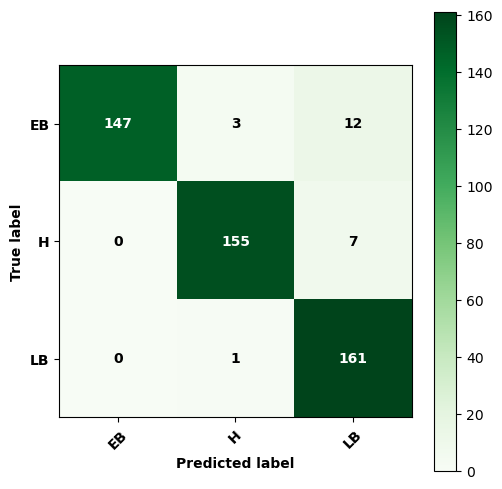

In [61]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [62]:
test_predict_class = np.argmax(y_pred, axis=1)
test_true = np.argmax(y_test, axis=1)

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_test = format(accuracy_score(test_true, test_predict_class)*100,'.3f')
precision_test = format( precision_score(test_true, test_predict_class, average='macro')*100,'.3f')
recall_test = format(recall_score(test_true, test_predict_class, average='macro')*100,'.3f')
f1_test = format(f1_score(test_true, test_predict_class, average='macro')*100,'.3f')

In [64]:
# make predictions on the train data
y_pred = model.predict(X_train)

138/138 [==============================] - 17s 120ms/step


Confusion matrix, without normalization


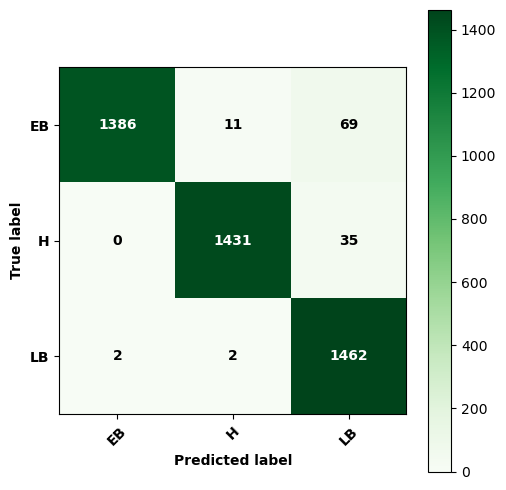

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [66]:
train_predict_class = np.argmax(y_pred, axis=1)
train_true = np.argmax(y_train, axis=1)

In [67]:
accuracy_train = format(accuracy_score(train_true, train_predict_class)*100,'.3f')
precision_train = format( precision_score(train_true, train_predict_class, average='macro')*100,'.3f')
recall_train = format(recall_score(train_true, train_predict_class, average='macro')*100,'.3f')
f1_train = format(f1_score(train_true, train_predict_class, average='macro')*100,'.3f')

In [68]:
model_name='ResNet152'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [69]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,ResNet50,98.954,98.963,98.954,98.953,98.560,98.595,98.560,98.565,228.224684,2.188679,5210.652344
1,ResNet50V2,99.477,99.480,99.477,99.477,97.737,97.781,97.737,97.720,231.126462,1.963836,5937.468750
2,ResNet101,98.749,98.756,98.749,98.748,97.119,97.143,97.119,97.116,373.155548,3.202658,6855.910156
3,ResNet101V2,96.226,96.375,96.226,96.201,94.650,94.931,94.650,94.579,377.864237,3.049969,7480.601562
4,ResNet152,97.294,97.438,97.294,97.305,95.267,95.643,95.267,95.290,583.700724,4.904333,8612.796875


**ResNet152V2**

In [70]:
# Define the model
base_model = tf.keras.applications.ResNet152V2(
    include_top=True,  # Include the fully connected layers (classifier)
    weights="imagenet",  # Use pretrained weights from ImageNet
    input_shape=(image_size, image_size, 3),  # Input size of the images
    classifier_activation="softmax",  # Activation for the output layer
)

# Modify the final dense layer for 3-class classification
model = tf.keras.models.Model(
    inputs=base_model.input,  
    outputs=tf.keras.layers.Dense(3, activation='softmax')(base_model.layers[-2].output)  # Replace the last dense layer
)

# Compile the model
model.compile(
    loss="categorical_crossentropy",  # Loss function for multi-class classification
    optimizer="Adam",  # Optimization algorithm
    metrics=["accuracy"],  # Track accuracy during training
)

# Summary of the model
model.summary()

242745792/242745792 [==============================] - 1s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [71]:
import time

# Start timer
start_time = time.time()

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor ('val_loss' or 'val_accuracy')
    patience=5,                # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model
history = model.fit(
    X_train,             # Training images
    y_train,             # One-hot encoded labels
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=30,           # Number of epochs
    batch_size=32,       # Batch size for training
    verbose=1,            # Show detailed logs during training
    callbacks=[early_stopping] # Add EarlyStopping callback
)

# Measure training time
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate memory usage (optional, requires `psutil` library)
import psutil
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024
print(f"Memory Usage: {memory_usage:.2f} MB")

Epoch 1/30
110/110 [==============================] - 151s 443ms/step - loss: 0.4860 - accuracy: 0.8263 - val_loss: 8.7889 - val_accuracy: 0.2545
Epoch 2/30
110/110 [==============================] - 45s 410ms/step - loss: 0.2185 - accuracy: 0.9295 - val_loss: 0.8030 - val_accuracy: 0.7750
Epoch 3/30
110/110 [==============================] - 45s 409ms/step - loss: 0.1215 - accuracy: 0.9650 - val_loss: 0.7233 - val_accuracy: 0.8023
Epoch 4/30
110/110 [==============================] - 45s 406ms/step - loss: 0.1189 - accuracy: 0.9605 - val_loss: 0.7282 - val_accuracy: 0.9023
Epoch 5/30
110/110 [==============================] - 45s 409ms/step - loss: 0.0940 - accuracy: 0.9667 - val_loss: 0.1873 - val_accuracy: 0.9580
Epoch 6/30
110/110 [==============================] - 45s 408ms/step - loss: 0.0642 - accuracy: 0.9781 - val_loss: 0.0523 - val_accuracy: 0.9909
Epoch 7/30
110/110 [==============================] - 45s 405ms/step - loss: 0.0506 - accuracy: 0.9855 - val_loss: 0.1669 - val_a

In [72]:
# make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
testing_time = time.time() - start_time

16/16 [==============================] - 4s 122ms/step


Confusion matrix, without normalization


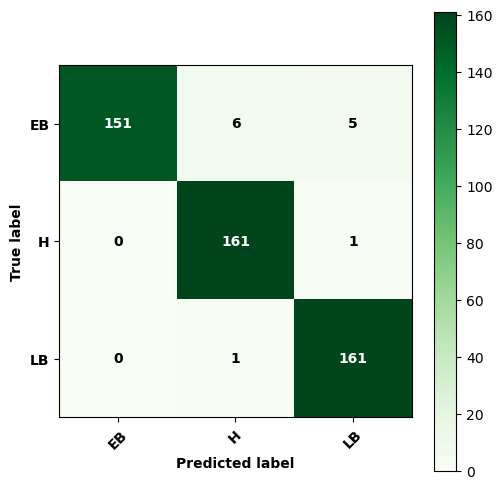

In [73]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [74]:
test_predict_class = np.argmax(y_pred, axis=1)
test_true = np.argmax(y_test, axis=1)

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_test = format(accuracy_score(test_true, test_predict_class)*100,'.3f')
precision_test = format( precision_score(test_true, test_predict_class, average='macro')*100,'.3f')
recall_test = format(recall_score(test_true, test_predict_class, average='macro')*100,'.3f')
f1_test = format(f1_score(test_true, test_predict_class, average='macro')*100,'.3f')

In [76]:
# make predictions on the train data
y_pred = model.predict(X_train)

138/138 [==============================] - 17s 121ms/step


Confusion matrix, without normalization


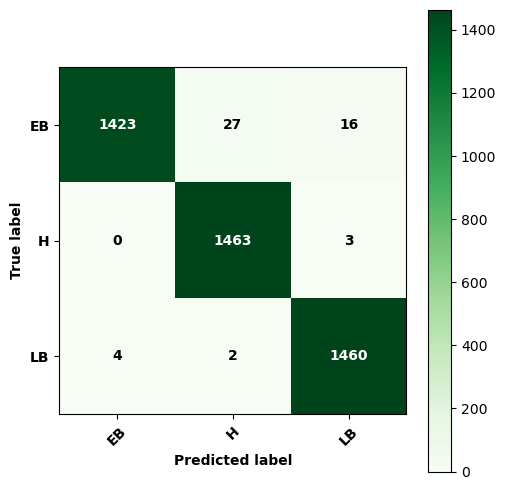

In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [78]:
train_predict_class = np.argmax(y_pred, axis=1)
train_true = np.argmax(y_train, axis=1)

In [79]:
accuracy_train = format(accuracy_score(train_true, train_predict_class)*100,'.3f')
precision_train = format( precision_score(train_true, train_predict_class, average='macro')*100,'.3f')
recall_train = format(recall_score(train_true, train_predict_class, average='macro')*100,'.3f')
f1_train = format(f1_score(train_true, train_predict_class, average='macro')*100,'.3f')

In [80]:
model_name='ResNet152V2'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [81]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,ResNet50,98.954,98.963,98.954,98.953,98.560,98.595,98.560,98.565,228.224684,2.188679,5210.652344
1,ResNet50V2,99.477,99.480,99.477,99.477,97.737,97.781,97.737,97.720,231.126462,1.963836,5937.468750
2,ResNet101,98.749,98.756,98.749,98.748,97.119,97.143,97.119,97.116,373.155548,3.202658,6855.910156
3,ResNet101V2,96.226,96.375,96.226,96.201,94.650,94.931,94.650,94.579,377.864237,3.049969,7480.601562
4,ResNet152,97.294,97.438,97.294,97.305,95.267,95.643,95.267,95.290,583.700724,4.904333,8612.796875
5,ResNet152V2,98.818,98.830,98.818,98.815,97.325,97.414,97.325,97.311,600.383743,4.644015,9366.343750
